In [1102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1103]:
#from config import path_to_repository
from pathlib import Path
path_to_repository = Path("/Users/hannas/Desktop/SNEL/kinematics/Strain-Sensor-")
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
from analysis_adc_cam import ADC_CAM
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1104]:
# Upload Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

root_dir="CSV Data/11_7_25"
folder_suffix_first  = "B1_fast"       # e.g.  9_19_25_B1_slow
folder_suffix_second = "B2_fast"       # e.g.  9_19_25_B2_slow

#10_28_25 (Tom)
#10_29_25 (bending data might be okay...check...resistance changing)
#11_2_25 (good)
#11_4_25 (good)
#11_7_25 (missing 90 degree cam calibration)

##################### raw adc or imu data for any test ###############################



cam = ADC_CAM(
    root_dir=root_dir,
    path_to_repo=path_to_repository,
    folder_suffix_first=folder_suffix_first,
    folder_suffix_second=folder_suffix_second,
)

first_trials  = cam.load_first()
second_trials = cam.load_second()

n_first  = len(first_trials)
n_second = len(second_trials)

print("Number of first trials:", n_first)
print("Number of second trials:", n_second)


Number of first trials: 2
Number of second trials: 2


## Obtain raw ADC traces for tasks

In [1105]:
adc_trials_first  = cam.extract_adc_dfs_by_trial(first_trials)
adc_trials_second = cam.extract_adc_dfs_by_trial(second_trials)

print("Number of first ADC trials:", len(adc_trials_first))
print("Number of second ADC trials:", len(adc_trials_second))


Number of first ADC trials: 2
Number of second ADC trials: 2


##  Obtain Camera/Protractor Calibration data and plot

,set,folder_name,angle_raw_deg,angle_snap_deg,adc_column,adc_mean,source_path
0,1,2025_11_07_09_58_50_B_calib45,45.0,45.0,adc_ch3,9.016339e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
1,2,2025_11_07_11_00_42_B_calib45,45.0,45.0,adc_ch3,8.981846e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
2,1,2025_11_07_09_57_52_B_calib22,22.0,22.0,adc_ch3,9.059894e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
3,2,2025_11_07_10_59_59_B_calib22,22.0,22.0,adc_ch3,9.031218e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
4,1,2025_11_07_10_00_20_B_calib67,67.0,67.0,adc_ch3,8.958327e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
5,2,2025_11_07_11_01_42_B_calib67,67.0,67.0,adc_ch3,8.840585e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
6,1,2025_11_07_09_56_42_B_calib0,0.0,0.0,adc_ch3,9.121694e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...
7,2,2025_11_07_10_58_40_B_calib0,0.0,0.0,adc_ch3,9.099329e+06,/Users/hannas/Desktop/SNEL/kinematics/Strain-S...


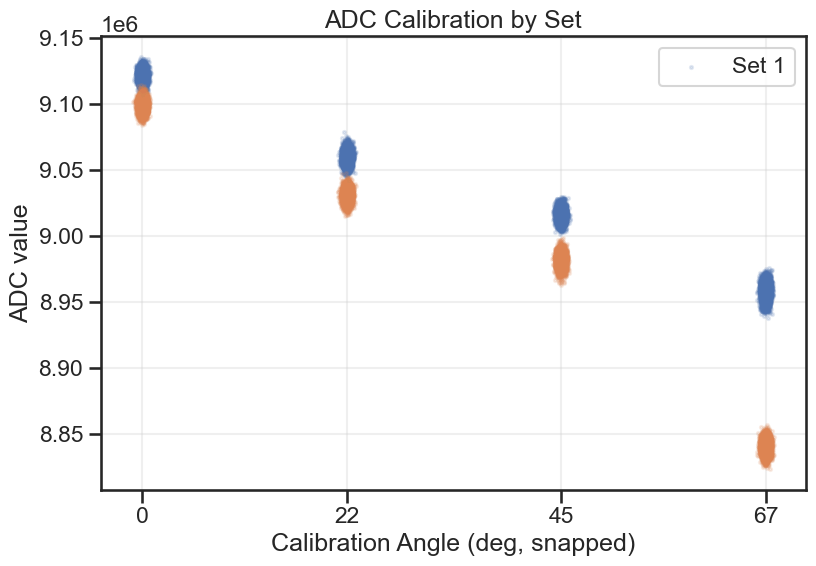

In [1106]:
adc_cal_df = cam.extract_calib_means_by_set(
    adc_column="adc_ch3",             # or None to auto-pick
    exclude_name_contains=("C_Block",),
    exclude_sets=(3, 4),
    make_plot=True,
    overlay_mean=False,
    point_alpha=0.15,                 # maybe lower alpha for all points
    point_size=5,                     # smaller points for dense clouds
    jitter=0.25,
    snap_tol_deg=4.0,
    plot_all_data=True,               # <-- THIS plots all ADC samples
    canonical_angles=(0, 22, 45, 67), #  no 90
)

adc_cal_df


## Convert ADC values to angles using Camera / Protractor Calibration

In [1107]:
out_cam = cam.calibrate_trials_with_camera(
    adc_trials_first=adc_trials_first,
    adc_trials_second=adc_trials_second,
    adc_column="adc_ch3",
    poly_order=2,
    calib_kwargs=dict(
        adc_column="adc_ch3",
        exclude_name_contains=("C_Block",),
        exclude_sets=(3, 4),
        make_plot=False,
        overlay_mean=False,
        point_alpha=0.25,
        point_size=10,
        jitter=0.25,
        snap_tol_deg=4.0,
    ),
    clamp_theta=True,   # <--- enable clamping
    deg_min=0.0,
    deg_max=90.0,
)

adc_first_theta  = out_cam["adc_trials_first_theta"]
adc_second_theta = out_cam["adc_trials_second_theta"]



# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

## NOTE:  NO LONGER USING .mat data for timestamp alignment!

In [1108]:
# ---------- 1) FLIR MAT per trial ----------
#cam_trials_first = cam.extract_mat_dfs_by_trial(
#    first_trials,
#    mat_name="flir_data.mat",   # this matches your flir_data_*.mat files
#    prefix="ts",
#    add_labels=True,
#    trial_base=1,
#    set_label="first_cam",
#    include_path=True,
#)

#cam_trials_second = cam.extract_mat_dfs_by_trial(
#    second_trials,
#    mat_name="flir_data.mat",
#    prefix="ts",
#    add_labels=True,
#    trial_base=1,
#    set_label="second_cam",
#    include_path=True,
#)

#print("FLIR first:",  len(cam_trials_first))
#print("FLIR second:", len(cam_trials_second))




# Get per-trial camera timestamp tables from data_trigger_time csv fles (prefix 'ts*') 

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [1109]:
cam_trials_first = cam.extract_trigger_time_dfs_by_trial(
    first_trials,
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

cam_trials_second = cam.extract_trigger_time_dfs_by_trial(
    second_trials,
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

print("Trig first:",  len(cam_trials_first))
print("Trig second:", len(cam_trials_second))


Trig first: 2
Trig second: 2


# Extract DLC3D point data from csv's

In [1110]:
# ---------- 2) DLC 3D per trial ----------
dlc3d_trials_first = cam.extract_dlc3d_dfs_by_trial(
    first_trials,
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

dlc3d_trials_second = cam.extract_dlc3d_dfs_by_trial(
    second_trials,
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

print("DLC first:",  len(dlc3d_trials_first))
print("DLC second:", len(dlc3d_trials_second))


DLC first: 2
DLC second: 2


# The DLC3d Data has a multiindex column naming, so need to split up

In [1111]:
# ---------- 3) Coerce DLC columns to MultiIndex using ADC_CAM helper ----------
dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]



In [1112]:
# ---------- 4) Compute MCP + wrist angles (per trial) ----------
dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

aug_first,  tall_first  = cam.compute_dlc3d_angles_by_trial(
    dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
)
aug_second, tall_second = cam.compute_dlc3d_angles_by_trial(
    dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
)

print("len(aug_first) vs cam_trials_first:",
      len(aug_first), "vs", len(cam_trials_first))

print("len(aug_second) vs cam_trials_second:",
      len(aug_second), "vs", len(cam_trials_second))




len(aug_first) vs cam_trials_first: 2 vs 2
len(aug_second) vs cam_trials_second: 2 vs 2


## Combine DLC3D bend angles and timestamp data

In [1113]:
# ---------- 5) Attach FLIR timestamps to DLC angle trials ----------
dlc3D_angles_first  = cam.attach_cam_timestamps_to_angles(
    cam_trials_first,
    aug_first,
    time_col_name="timestamp",     # from _mat_to_df
    new_col_name="cam_timestamp",  # name of column in angles dfs
)

dlc3D_angles_second = cam.attach_cam_timestamps_to_angles(
    cam_trials_second,
    aug_second,
    time_col_name="timestamp",
    new_col_name="cam_timestamp",
)

print("len(dlc3D_angles_first):",  len(dlc3D_angles_first))
print("len(dlc3D_angles_second):", len(dlc3D_angles_second))





len(dlc3D_angles_first): 2
len(dlc3D_angles_second): 2


## Filter rows with low likelihood DLC estimation

In [1114]:
# Filter out low-likelihood frames before doing ADC alignment / comparisons
dlc3D_angles_first_filt = cam.filter_angle_trials_by_likelihood(
    dlc3D_angles_first,
    bodyparts=("MCP", "PIP", "hand"),
    min_likelihood=0.45,  # this should be same as IMU data
)

dlc3D_angles_second_filt = cam.filter_angle_trials_by_likelihood(
    dlc3D_angles_second,
    bodyparts=("MCP", "PIP", "hand"),
    min_likelihood=0.45,
)

print(len(dlc3D_angles_first[0]),  len(dlc3D_angles_first_filt[0]))
print(len(dlc3D_angles_second[0]), len(dlc3D_angles_second_filt[0]))

197 197
198 198


## Align Timestamps

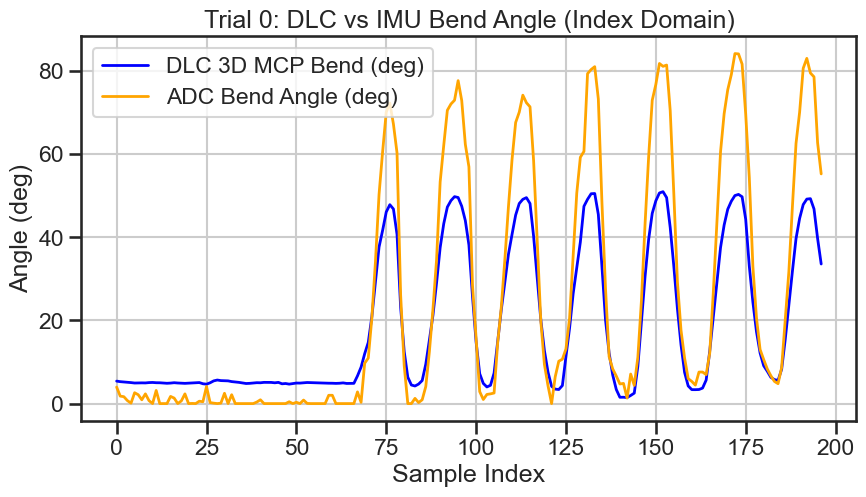

In [1115]:
# Align FIRST set: DLC MCP angles vs ADC-calibrated angles
merged_first = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_first_filt,
    adc_theta_trials=adc_first_theta,
    dlc_time_col="cam_timestamp",    # from attach_cam_timestamps_to_angles
    adc_time_col="timestamp",        # column in adc_first_theta
    adc_cols=["theta_cam_cal"],      # or None to attach all ADC columns
    time_unit="ns",                   # <-- try 's' first; use 'ms' if your timestamps are in milliseconds
    tolerance="50ms",
    direction="nearest",
    suffix="_adc",
    keep_time_delta=True,
    drop_unmatched=True,
)

# Align SECOND set
merged_second = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_second_filt,
    adc_theta_trials=adc_second_theta,
    dlc_time_col="cam_timestamp",
    adc_time_col="timestamp",
    adc_cols=["theta_cam_cal"],
    time_unit="ns",
    tolerance="50ms",
    direction="nearest",
    suffix="_adc",
    keep_time_delta=True,
    drop_unmatched=True,
)

#-----EXAMPLE PLOTTING-------#

trial_idx = 0

# IMU column from alignment step
IMU_COL = "theta_cam_cal_adc"   # your OUT_COL

# DLC 3D angle column (MultiIndex: ('metric','mcp_bend_deg','deg'))
DLC_COL = ("metric", "mcp_bend_deg", "deg")

df = merged_first[trial_idx]

# Extract DLC angle column
dlc_angle = df[DLC_COL]
imu_angle = df[IMU_COL]

# Make plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dlc_angle.values, label="DLC 3D MCP Bend (deg)", color="blue", linewidth=2)
ax.plot(imu_angle.values, label="ADC Bend Angle (deg)", color="orange", linewidth=2)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Angle (deg)")
ax.set_title(f"Trial {trial_idx}: DLC vs IMU Bend Angle (Index Domain)")
ax.grid(True)
#ax.set_ylim(-10, 180)
ax.legend()

plt.show()




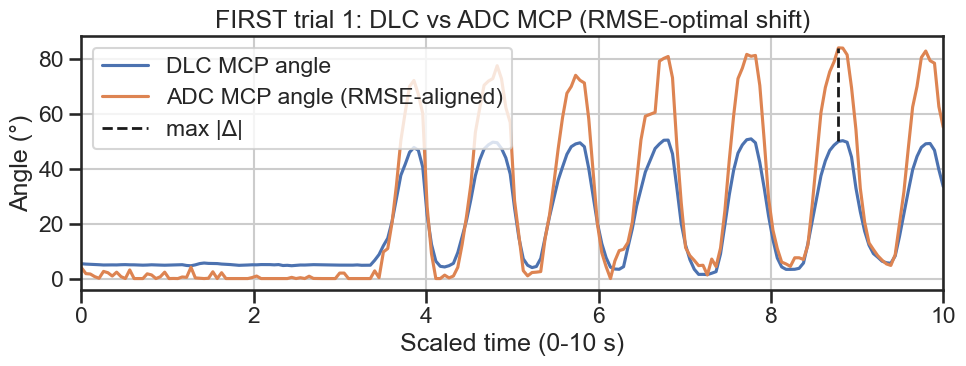

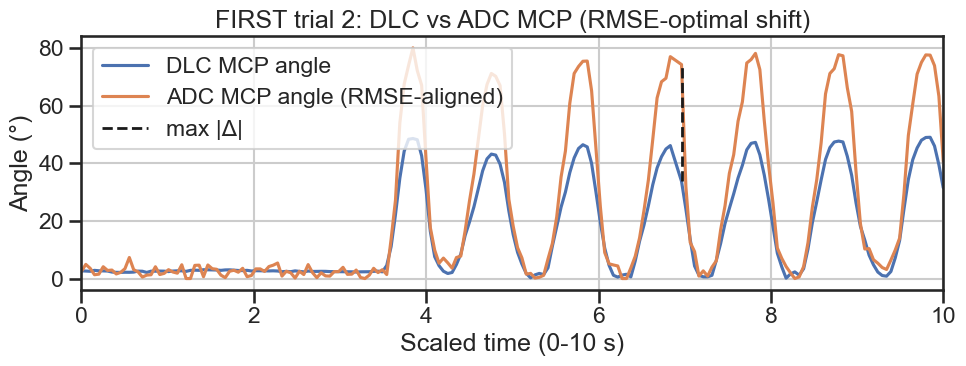

   trial_index  best_lag_samples   rmse_deg  n_points
0            0                 0  13.849724       197
1            1                 0  13.181315       197


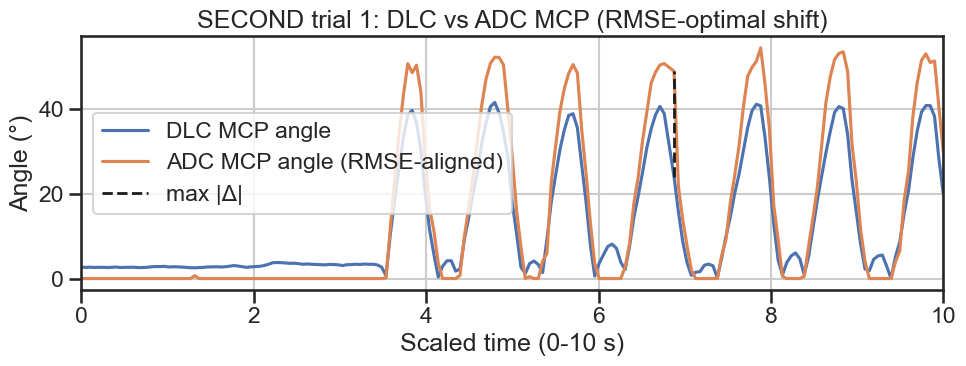

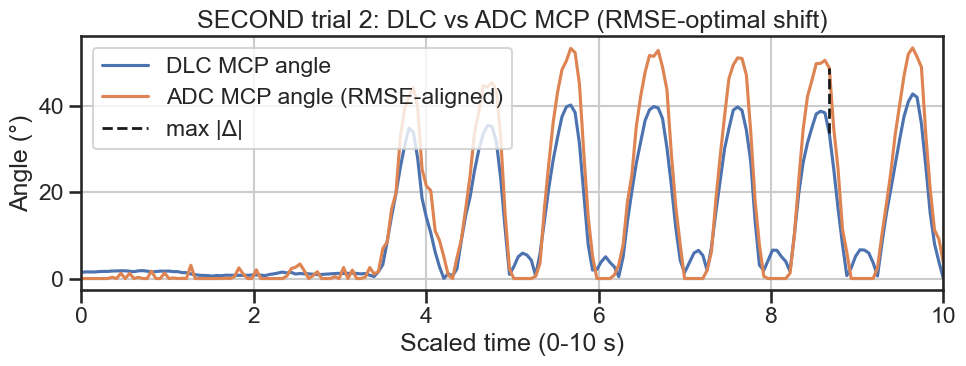

   trial_index  best_lag_samples  rmse_deg  n_points
0            0                 0  6.683459       198
1            1                 0  6.157979       197


In [1116]:
# Refine FIRST set and plot a few trials
refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_first,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_col="theta_cam_cal_adc",
    max_lag_samples=100, 
    time_col=("_t_cam_td", "", ""),   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="FIRST",
    do_refine=False,                 # <--- NO further alignment
)

print(summary_first)

# Refine SECOND set and plot a few trials
refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_second,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_col="theta_cam_cal_adc",
    max_lag_samples=100, 
    time_col=("_t_cam_td", "", ""),   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="SECOND",
    do_refine=False,                 # <--- NO further alignment
)

print(summary_second)


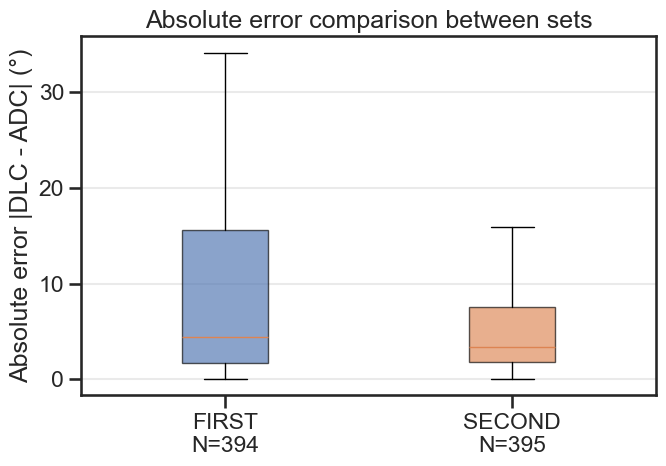

In [1117]:
cam.plot_abs_error_box_two_sets(
    refined_first=refined_first,
    summary_first=summary_first,
    refined_second=refined_second,
    summary_second=summary_second,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_rmse_col="theta_cam_cal_adc_rmse",
    trial_indices_first=[0, 1],    # FIRST set: trials 1 & 2 (0-based)
    trial_indices_second=[0, 1],   # SECOND set: trials 1 & 3
    label_first="FIRST",
    label_second="SECOND",
)




## New reapplied version
Blue Boxes
→ Self-calibrated condition

1st application trials are converted to angle using the 1st calibration curve (their own quadratic fit).

2nd application trials are converted to angle using the 2nd calibration curve (their own quadratic fit).

Red Boxes
→ Cross-trained / recalibrated condition

We take the 1st calibration curve, convert it to a normalized 0–1 scale using its own min/max ADC.

Then we rescale that normalized calibration curve to the min and max ADC of the 2nd calibration data, producing a second-application-mapped version of the first calibration curve.

This re-mapped calibration curve is used to convert 2nd application trials to angle.

# Below method could be written as a @staticmethod in analysis_adc_cam.py

In [1118]:
from typing import Optional, Sequence
from analysis_adc_cam import ADC_CAM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_adc_cam_pipeline_for_participant_speed(
    root_dir: str,
    speed_tag: str,
    *,
    path_to_repo: str,
    adc_column: str = "adc_ch3",
    calib_kwargs: Optional[dict] = None,
    time_unit: str = "ns",
    align_tolerance: str = "50ms",
    max_lag_samples: int = 100,  # kept in signature but NOT used for refinement below
    trial_indices_first: Optional[Sequence[int]] = None,
    trial_indices_second: Optional[Sequence[int]] = None,
    min_dlc_likelihood: float = 0.9,
    # NEW: allow specifying canonical calibration angles (deg)
    canonical_angles: Optional[Sequence[float]] = None,
) -> dict:
    """
    Run the full ADC_CAM pipeline for a given participant/date (root_dir)
    and one speed condition (slow, medm, fast, vfas, afap).

    Now also computes a cross-trained calibration for the SECOND application,
    using the first application's calibration shape (blue = self, red = cross).

    Parameters
    ----------
    ...
    min_dlc_likelihood : float, default 0.9
        DLC likelihood threshold for MCP/PIP/hand filtering.
    canonical_angles : sequence of float or None, default None
        Canonical calibration angles (deg) to use inside
        extract_calib_means_by_set. If None, that method's default
        is used (e.g. (0, 22, 45, 67, 90)).
    """

    # 1) Build ADC_CAM for this speed
    folder_suffix_first = f"B1_{speed_tag}"
    folder_suffix_second = f"B2_{speed_tag}"

    cam = ADC_CAM(
        root_dir=root_dir,
        path_to_repo=path_to_repo,
        folder_suffix_first=folder_suffix_first,
        folder_suffix_second=folder_suffix_second,
    )

    # 2) Load raw trials (paths)
    first_trials = cam.load_first()
    second_trials = cam.load_second()

    if len(first_trials) == 0 and len(second_trials) == 0:
        return {
            "abs_err_first": np.array([]),
            "abs_err_second": np.array([]),
            "abs_err_second_cross": np.array([]),
            "summary_first": pd.DataFrame(),
            "summary_second": pd.DataFrame(),
            "summary_second_cross": pd.DataFrame(),  # fixed typo
        }

    # 3) Load ADC CSVs per trial
    adc_first = cam.extract_adc_dfs_by_trial(first_trials)
    adc_second = cam.extract_adc_dfs_by_trial(second_trials)

    # --- NEW: inject canonical_angles into calib_kwargs if provided ---
    if calib_kwargs is None:
        calib_kwargs = {}
    else:
        calib_kwargs = dict(calib_kwargs)  # shallow copy so we don't mutate caller

    if canonical_angles is not None:
        calib_kwargs["canonical_angles"] = tuple(canonical_angles)

    # 4) Camera-based calibration (ADC -> theta), SELF for both sets
    calib_result = cam.calibrate_trials_with_camera(
        adc_trials_first=adc_first,
        adc_trials_second=adc_second,
        adc_column=adc_column,
        poly_order=2,
        calib_kwargs=calib_kwargs,
        clamp_theta=True,
        deg_min=0.0,
        deg_max=90.0,
    )

    calib_df         = calib_result["calib_df"]
    adc_first_theta  = calib_result["adc_trials_first_theta"]
    adc_second_theta = calib_result["adc_trials_second_theta"]

    # 4b) CROSS-trained calibration for second application
    cross_result = cam.reapply_first_calibration_to_second(
        calib_df=calib_df,
        adc_trials_second=adc_second,
        adc_column=adc_column,
        poly_order=2,
        deg_min=0.0,
        deg_max=90.0,
        new_col="theta_cam_cal_xtrained",
        clamp_theta=True,
    )
    adc_second_theta_cross = cross_result["adc_trials_second_theta_cross"]

    # 5) Trigger-time CSV per trial (timestamps)  **REPLACES FLIR MAT**
    cam_trials_first = cam.extract_trigger_time_dfs_by_trial(
        first_trials,
        add_labels=True,
        trial_base=1,
        set_label="first_cam",
        include_path=True,
    )
    cam_trials_second = cam.extract_trigger_time_dfs_by_trial(
        second_trials,
        add_labels=True,
        trial_base=1,
        set_label="second_cam",
        include_path=True,
    )

    # 6) DLC per trial
    dlc3d_trials_first = cam.extract_dlc3d_dfs_by_trial(
        first_trials,
        add_labels=True,
        trial_base=1,
        set_label="first_cam",
        include_path=True,
    )
    dlc3d_trials_second = cam.extract_dlc3d_dfs_by_trial(
        second_trials,
        add_labels=True,
        trial_base=1,
        set_label="second_cam",
        include_path=True,
    )

    # 7) Coerce DLC -> MultiIndex and compute angles
    dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
    dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

    aug_first,  _ = cam.compute_dlc3d_angles_by_trial(
        dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
    )
    aug_second, _ = cam.compute_dlc3d_angles_by_trial(
        dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
    )

    # 8) Attach trigger timestamps to DLC angle trials
    dlc3D_angles_first = cam.attach_cam_timestamps_to_angles(
        cam_trials_first,
        aug_first,
        time_col_name="timestamp",
        new_col_name="cam_timestamp",
    )
    dlc3D_angles_second = cam.attach_cam_timestamps_to_angles(
        cam_trials_second,
        aug_second,
        time_col_name="timestamp",
        new_col_name="cam_timestamp",
    )

    # 8b) Filter out low-likelihood DLC rows before alignment
    dlc3D_angles_first = cam.filter_angle_trials_by_likelihood(
        dlc3D_angles_first,
        bodyparts=("MCP", "PIP", "hand"),
        min_likelihood=min_dlc_likelihood,
    )
    dlc3D_angles_second = cam.filter_angle_trials_by_likelihood(
        dlc3D_angles_second,
        bodyparts=("MCP", "PIP", "hand"),
        min_likelihood=min_dlc_likelihood,
    )

    # 9) Align ADC-theta to DLC angles (time-based): SELF calibrations
    merged_first = cam.align_adc_theta_to_dlc_angles_for_set(
        dlc_angle_trials=dlc3D_angles_first,
        adc_theta_trials=adc_first_theta,
        dlc_time_col="cam_timestamp",
        adc_time_col="timestamp",
        adc_cols=["theta_cam_cal"],
        time_unit=time_unit,
        tolerance=align_tolerance,
        direction="nearest",
        suffix="_adc",
        keep_time_delta=True,
        drop_unmatched=True,
    )

    merged_second = cam.align_adc_theta_to_dlc_angles_for_set(
        dlc_angle_trials=dlc3D_angles_second,
        adc_theta_trials=adc_second_theta,
        dlc_time_col="cam_timestamp",
        adc_time_col="timestamp",
        adc_cols=["theta_cam_cal"],
        time_unit=time_unit,
        tolerance=align_tolerance,
        direction="nearest",
        suffix="_adc",
        keep_time_delta=True,
        drop_unmatched=True,
    )

    # 9b) Align ADC-theta to DLC angles (time-based): CROSS-trained calibrations
    merged_second_cross = cam.align_adc_theta_to_dlc_angles_for_set(
        dlc_angle_trials=dlc3D_angles_second,
        adc_theta_trials=adc_second_theta_cross,
        dlc_time_col="cam_timestamp",
        adc_time_col="timestamp",
        adc_cols=["theta_cam_cal_xtrained"],
        time_unit=time_unit,
        tolerance=align_tolerance,
        direction="nearest",
        suffix="_adc",
        keep_time_delta=True,
        drop_unmatched=True,
    )

    # 10) RMSE-based refinement (SELF) -- DISABLED (no further alignment)
    refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
        merged_trials=merged_first,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_col="theta_cam_cal_adc",
        max_lag_samples=0,  # <- NO lag refinement
        time_col=("_t_cam_td", "", ""),
        plot_indices=None,
        set_name=f"{speed_tag.upper()} FIRST",
        do_refine=False,                 # <--- NO further alignment
    )

    refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
        merged_trials=merged_second,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_col="theta_cam_cal_adc",
        max_lag_samples=0,  # <- NO lag refinement
        time_col=("_t_cam_td", "", ""),
        plot_indices=None,
        set_name=f"{speed_tag.upper()} SECOND (self)",
        do_refine=False,                 # <--- NO further alignment
    )

    # 10b) RMSE-based refinement (CROSS) -- DISABLED (no further alignment)
    refined_second_cross, summary_second_cross = cam.refine_alignment_by_rmse_for_set(
        merged_trials=merged_second_cross,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_col="theta_cam_cal_xtrained_adc",
        max_lag_samples=0,  # <- NO lag refinement
        time_col=("_t_cam_td", "", ""),
        plot_indices=None,
        set_name=f"{speed_tag.upper()} SECOND (cross)",
    )

    # 11) Collect abs-error distributions using explicit trial indices
    abs_err_first = cam.collect_abs_error_for_set(
        refined_first,
        summary_first,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_rmse_col="theta_cam_cal_adc_rmse",
        trial_indices=trial_indices_first,
        n_best=2,
    )

    abs_err_second = cam.collect_abs_error_for_set(
        refined_second,
        summary_second,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_rmse_col="theta_cam_cal_adc_rmse",
        trial_indices=trial_indices_second,
        n_best=2,
    )

    abs_err_second_cross = cam.collect_abs_error_for_set(
        refined_second_cross,
        summary_second_cross,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_rmse_col="theta_cam_cal_xtrained_adc_rmse",
        trial_indices=trial_indices_second,
        n_best=2,
    )

    return {
        "refined_first": refined_first,
        "refined_second": refined_second,
        "refined_second_cross": refined_second_cross,

        "abs_err_first": abs_err_first,
        "abs_err_second": abs_err_second,
        "abs_err_second_cross": abs_err_second_cross,
        "summary_first": summary_first,
        "summary_second": summary_second,
        "summary_second_cross": summary_second_cross,
    } 


In [1119]:
# supress warnings here 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Processing P1 - slow ...
Processing P1 - medm ...
Processing P1 - fast ...
Processing P1 - vfas ...
Processing P1 - afap ...
Processing P2 - slow ...
Processing P2 - medm ...
Processing P2 - fast ...
Processing P2 - vfas ...
Processing P2 - afap ...
Processing P3 - slow ...
Processing P3 - medm ...
Processing P3 - fast ...
Processing P3 - vfas ...
Processing P3 - afap ...
Processing P4 - slow ...
Processing P4 - medm ...
Processing P4 - fast ...
Processing P4 - vfas ...
Processing P4 - afap ...


/var/folders/6l/jmrrplj15wj_v49y196hw0cm0000gp/T/ipykernel_70901/2585206747.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/var/folders/6l/jmrrplj15wj_v49y196hw0cm0000gp/T/ipykernel_70901/2585206747.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/var/folders/6l/jmrrplj15wj_v49y196hw0cm0000gp/T/ipykernel_70901/2585206747.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/var/folders/6l/jmrrplj15wj_v49y196hw0cm0000gp/T/ipykernel_70901/2585206747.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

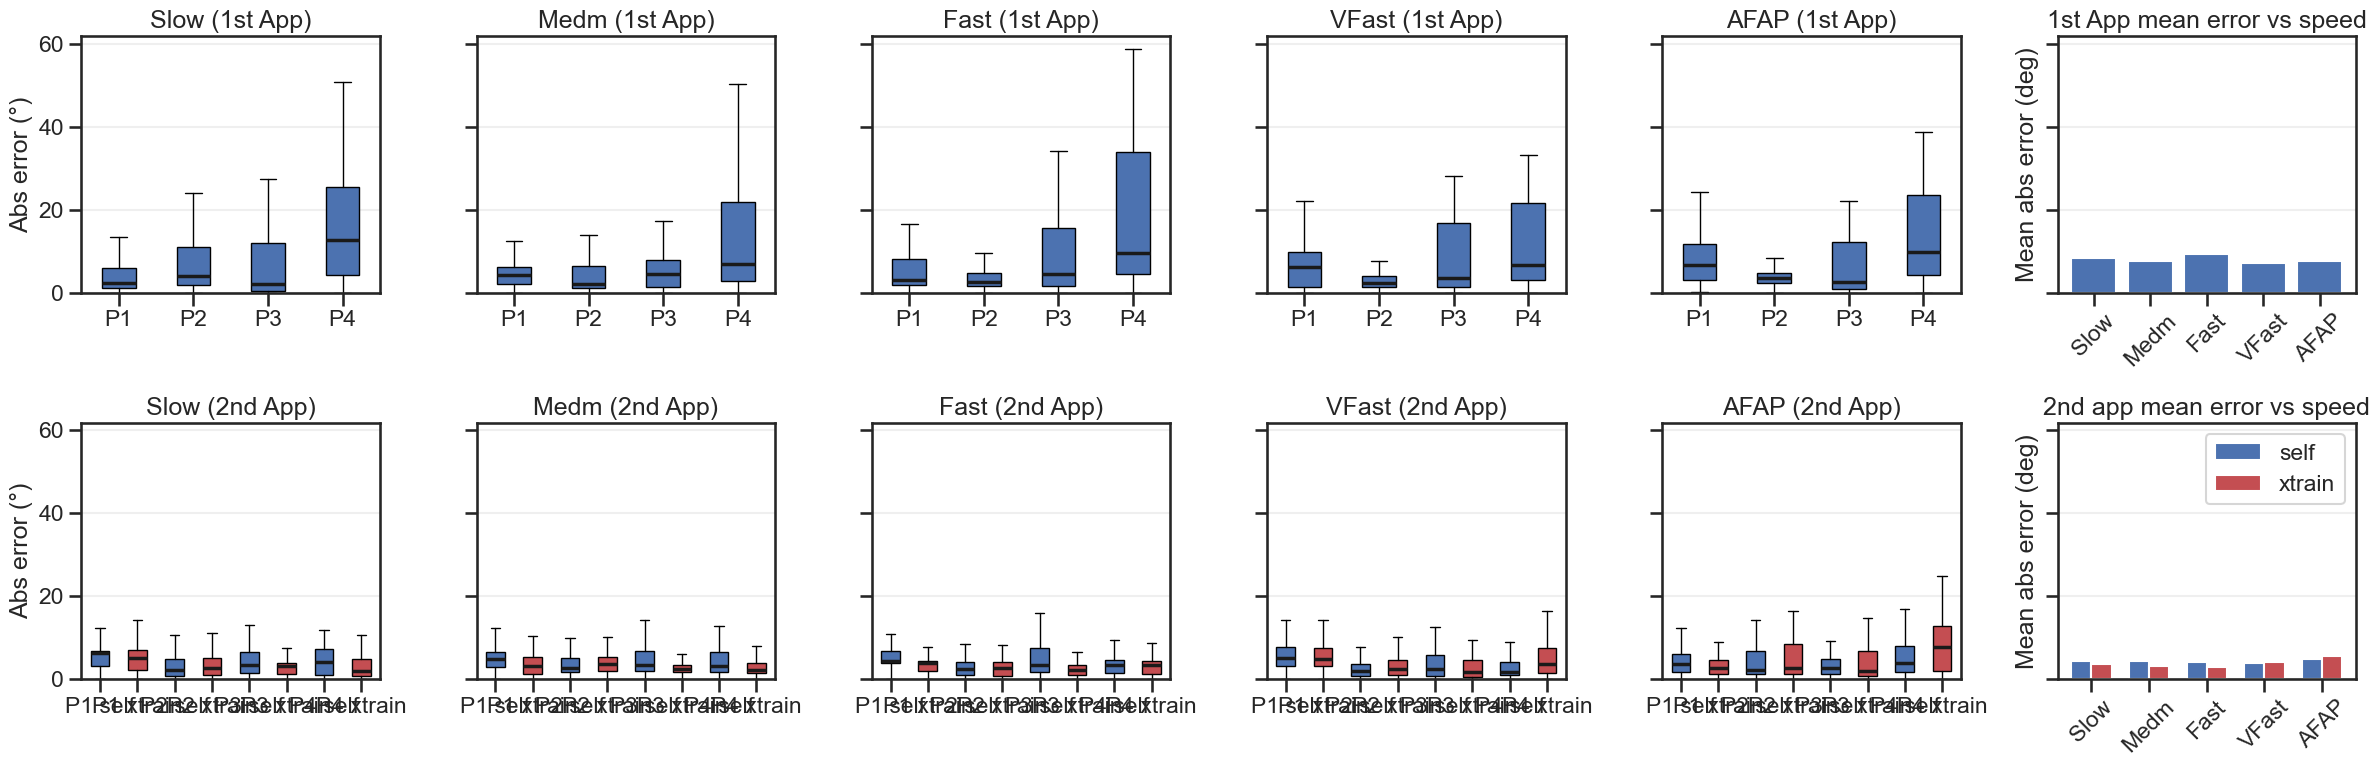

In [1120]:
# -----------------------------------------
# CONFIG: participants, speeds, and trial indices
# -----------------------------------------

participants = [
    {"name": "P1", "root_dir": "CSV Data/11_2_25"},
    {"name": "P2", "root_dir": "CSV Data/11_4_25"},
    {"name": "P3", "root_dir": "CSV Data/11_7_25"},
    {"name": "P4", "root_dir": "CSV Data/11_16_25"},
]

speed_tags   = ["slow", "medm", "fast", "vfas", "afap"]
speed_titles = ["Slow", "Medm", "Fast", "VFast", "AFAP"]

# Explicit trial indices to use for EACH speed + set
# (You can make this a dict keyed by speed/participant if you want more control.)
trial_indices_first_default  = [0, 1]  # B1_* application
trial_indices_second_default = [0, 1]  # B2_* application

# NEW: DLC likelihood threshold
min_dlc_likelihood = 0.45

# NEW: canonical calibration angles (drop 90°)
canonical_angles = (0, 22, 45, 67)


# -----------------------------------------
# Run pipeline for all (participant, speed)
# -----------------------------------------

results = {}  # (participant_name, speed_tag) -> dict from helper

for p in participants:
    for speed in speed_tags:
        key = (p["name"], speed)
        print(f"Processing {p['name']} - {speed} ...")
        res = run_adc_cam_pipeline_for_participant_speed(
            root_dir=p["root_dir"],
            speed_tag=speed,
            path_to_repo=path_to_repository,
            adc_column="adc_ch3",
            calib_kwargs=None,
            time_unit="ns",
            align_tolerance="50ms",
            max_lag_samples=100,
            trial_indices_first=trial_indices_first_default,
            trial_indices_second=trial_indices_second_default,
            min_dlc_likelihood=min_dlc_likelihood,
            canonical_angles=canonical_angles,   #  NEW
        )
        results[key] = res




# -----------------------------------------
# Build 2×6 summary figure:
# row 1: B1_* (FIRST application)
# row 2: B2_* (SECOND application, self vs cross)
# cols 1–5: per-speed boxplots
# col 6: summary bar (mean abs error vs speed)
# -----------------------------------------

fig, axes = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

def style_boxplot_with_colors(ax, data, labels, colors):
    """
    data  : list of 1D arrays
    labels: list of str, same len as data
    colors: list of matplotlib colors, same len as data
    """
    bp = ax.boxplot(
        data,
        labels=labels,
        showfliers=False,
        patch_artist=True,
    )
    # Color each box individually
    for box, c in zip(bp["boxes"], colors):
        box.set_facecolor(c)
    # Medians black + thick
    for med in bp["medians"]:
        med.set_color("k")
        med.set_linewidth(2.5)
    return bp

# --- row 1: FIRST set (B1_*) ---
for col, (speed, speed_title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[0, col]
    data = []
    labels = []
    colors = []

    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_first", np.array([]))
        if abs_err.size == 0:
            continue
        data.append(abs_err)
        labels.append(p["name"])   # e.g. P1, P2
        colors.append("C0")        # blue for first app

    if data:
        style_boxplot_with_colors(ax, data, labels, colors)
    ax.set_title(f"{speed_title} (1st App)")
    if col == 0:
        ax.set_ylabel("Abs error (°)")
    ax.grid(axis="y", alpha=0.3)

# --- row 2: SECOND set (B2_*), self (blue) vs cross (red) ---
for col, (speed, speed_title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[1, col]
    data = []
    labels = []
    colors = []

    for p in participants:
        key = (p["name"], speed)
        abs_self  = results.get(key, {}).get("abs_err_second",        np.array([]))
        abs_cross = results.get(key, {}).get("abs_err_second_cross", np.array([]))

        # Self-calibrated (blue)
        if abs_self.size > 0:
            data.append(abs_self)
            labels.append(f"{p['name']} self")
            colors.append("C0")  # blue

        # Cross-trained (red)
        if abs_cross.size > 0:
            data.append(abs_cross)
            labels.append(f"{p['name']} xtrain")
            colors.append("C3")  # red-ish

    if data:
        style_boxplot_with_colors(ax, data, labels, colors)
    ax.set_title(f"{speed_title} (2nd App)")
    if col == 0:
        ax.set_ylabel("Abs error (°)")
    ax.grid(axis="y", alpha=0.3)

# --- Column 6 (index 5): summary bar plots of mean error per speed ---

x = np.arange(len(speed_tags))

# Row 1 summary: FIRST set (single blue bar per speed)
ax_sum_first = axes[0, 5]
mean_first = []
for speed in speed_tags:
    all_err = []
    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_first", np.array([]))
        if abs_err.size > 0:
            all_err.append(abs_err)
    if all_err:
        all_err = np.concatenate(all_err)
        mean_first.append(np.nanmean(all_err))
    else:
        mean_first.append(np.nan)

ax_sum_first.bar(x, mean_first, color="C0")
ax_sum_first.set_xticks(x)
ax_sum_first.set_xticklabels(speed_titles, rotation=45)
ax_sum_first.set_ylabel("Mean abs error (deg)")
ax_sum_first.set_title("1st App mean error vs speed")
ax_sum_first.grid(axis="y", alpha=0.3)

# Row 2 summary: SECOND set (blue = self, red = cross)
ax_sum_second = axes[1, 5]

mean_second_self  = []
mean_second_cross = []

for speed in speed_tags:
    all_self  = []
    all_cross = []

    for p in participants:
        key = (p["name"], speed)
        abs_self  = results.get(key, {}).get("abs_err_second",        np.array([]))
        abs_cross = results.get(key, {}).get("abs_err_second_cross", np.array([]))

        if abs_self.size > 0:
            all_self.append(abs_self)
        if abs_cross.size > 0:
            all_cross.append(abs_cross)

    if all_self:
        all_self_concat = np.concatenate(all_self)
        mean_second_self.append(np.nanmean(all_self_concat))
    else:
        mean_second_self.append(np.nan)

    if all_cross:
        all_cross_concat = np.concatenate(all_cross)
        mean_second_cross.append(np.nanmean(all_cross_concat))
    else:
        mean_second_cross.append(np.nan)

width = 0.35
ax_sum_second.bar(x - width/2, mean_second_self,  width=width, color="C0", label="self")
ax_sum_second.bar(x + width/2, mean_second_cross, width=width, color="C3", label="xtrain")

ax_sum_second.set_xticks(x)
ax_sum_second.set_xticklabels(speed_titles, rotation=45)
ax_sum_second.set_ylabel("Mean abs error (deg)")
ax_sum_second.set_title("2nd app mean error vs speed")
ax_sum_second.grid(axis="y", alpha=0.3)
ax_sum_second.legend()

plt.tight_layout()
plt.show()


In [1121]:
calib_result = cam.calibrate_trials_with_camera(
    adc_trials_first,
    adc_trials_second,
    adc_column="adc_ch3",
    poly_order=2,
    calib_kwargs={
        "adc_column": "adc_ch3",
        "plot_all_data": False,
        "exclude_sets": (),  # keep 1 & 2 so set==2 is the orange SECOND
    },
)
calib_df = calib_result["calib_df"]


In [1122]:
# missing from Tom 

speed_tags   = ["slow", "medm", "fast", "vfas", "afap"]
speed_titles = ["30 BPM", "60 BPM", "120 BPM", "240 BPM", "AFAP"]
speed_title_map = {tag: title for tag, title in zip(speed_tags, speed_titles)}
#results = {}  # (participant_name, speed_tag) -> dict from helper

def get_result_block(participant: str, speed: str):
    """
    Convenience helper: fetch the per-(participant, speed) result dict.
    """
    return results[(participant, speed)]

def get_example_df(participant: str, speed: str, trial_idx: int):
    """
    Grab the refined SECOND-set time-series DataFrame for a single trial.
    This should have both the DLC and ADC angle columns that the plotting
    function uses (via dlc_angle_col & adc_angle_col).
    """
    block = get_result_block(participant, speed)
    refined_second = block["refined_second"]   # list/sequence of per-trial DataFrames
    return refined_second[trial_idx]

# Row 1 example: P3, B2_slow, trial 0
example1_df = get_example_df("P3", "slow", 0)

# Row 2 example: P3, B2_vfas, trial 1
example2_df = get_example_df("P3", "vfas", 1)



/Users/hannas/Desktop/SNEL/kinematics/Strain-Sensor-/Code/analysis/camera_sensor_imu_analysis/analysis_adc_cam.py:320: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  overlay_mean : bool, default False


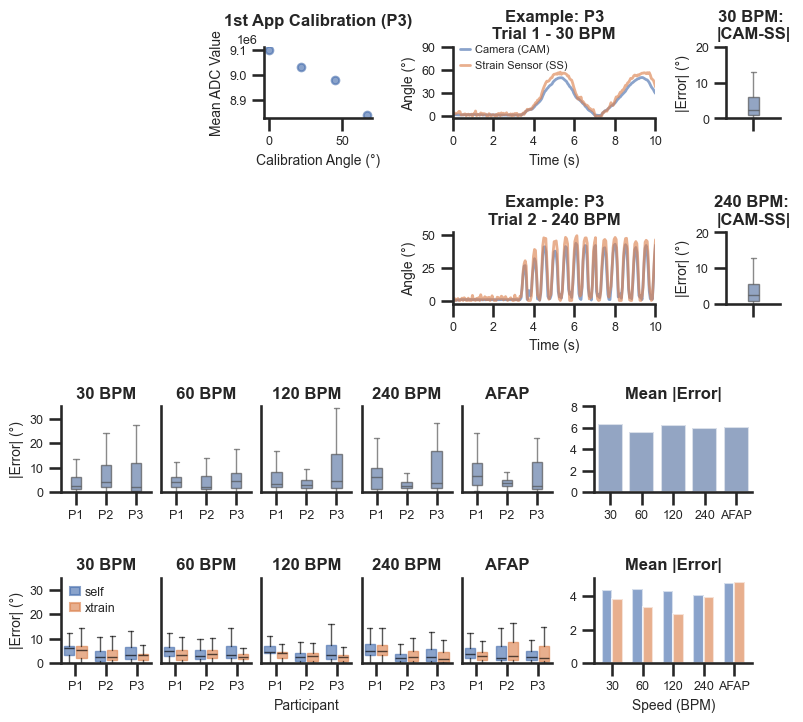

In [1123]:
fig, axes = cam.plot_adc_abs_error_summary_grid(
    results,
    speed_titles=speed_title_map,
    speed_order=speed_tags,
    dlc_angle_col=("metric", "mcp_bend_deg", "deg"),
    adc_angle_col="theta_cam_cal_adc",

    # Row 1: P3, B2_slow, trial 0
    example1_participant="P3",
    example1_speed="slow",
    example1_trial_idx=0,
    example1_df=example1_df,

    # Row 2: P3, B2_vfas, trial 1
    example2_participant="P3",
    example2_speed="vfas",
    example2_trial_idx=1,
    example2_df=example2_df,

    # NEW: calibration data (SECOND set, orange)
    calib_df=calib_df,
    calib_set_label=2,

    example_col_start=2,        # TS/box in cols 3 & 4; calib in col 2
    abs_err_ylim_examples=(0, 20),
    abs_err_ylim_summary=(0, 35),
    boxplot_wspace=0.1,
    example_col_gap_scale=7,
    bar_gap_from_afap=0.05,
    calib_x_shift=0.1,   # try 0.05, tune to taste

    exclude_participant_set_for_summary=[("P4", "FIRST"), ("P4", "SECOND")],
)
fig.savefig("fig 2.svg", bbox_inches="tight")
fig.savefig("fig 2.pdf", bbox_inches="tight")

In [1124]:
# ## NEED to toggle y-axis limits and ticks!!
## tagged with # SUPP in analysis_adc_cam.py

# fig, axes = cam.plot_adc_abs_error_summary_grid(
#     results,
#     speed_titles=speed_title_map,
#     speed_order=speed_tags,
#     dlc_angle_col=("metric", "mcp_bend_deg", "deg"),
#     adc_angle_col="theta_cam_cal_adc",

#     # Row 1: P3, B2_slow, trial 0
#     example1_participant="P3",
#     example1_speed="slow",
#     example1_trial_idx=0,
#     example1_df=example1_df,

#     # Row 2: P3, B2_vfas, trial 1
#     example2_participant="P3",
#     example2_speed="vfas",
#     example2_trial_idx=1,
#     example2_df=example2_df,

#     # NEW: calibration data (SECOND set, orange)
#     calib_df=calib_df,
#     calib_set_label=2,

#     example_col_start=2,        # TS/box in cols 3 & 4; calib in col 2
#     abs_err_ylim_examples=(0, 20),
#     abs_err_ylim_summary=(0, 35),
#     boxplot_wspace=0.1,
#     example_col_gap_scale=7,
#     bar_gap_from_afap=0.05,
#     calib_x_shift=0.1,   # try 0.05, tune to taste

#     exclude_participant_set_for_summary=[("P1", "FIRST"), ("P1", "SECOND"),
#                                          ("P2", "FIRST"), ("P2", "SECOND"),
#                                          ("P3", "FIRST"), ("P3", "SECOND")],
# )
# fig.savefig("fig 2 supp.svg", bbox_inches="tight")
# fig.savefig("fig 2 supp.pdf", bbox_inches="tight")